Course Recommendation System

For this project, we will be using the udemy courses dataset download from kaggle and uploaded to our github repository

In [1]:
# Link to the dataset
data_folder = "https://raw.githubusercontent.com/kueyram/Course-Recommendation/refs/heads/main/data/"
udemy_courses = f"{data_folder}udemy_courses.csv"
coursera_courses = f"{data_folder}coursera_courses.csv"

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import streamlit as st
from fuzzywuzzy import process

In [3]:
# Disabling all eventual warnings
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Importing the datasets into pandas dataframes
udemy_courses = pd.read_csv(udemy_courses, sep = ',')
coursera_courses = pd.read_csv(coursera_courses, sep = ',')

#### Udemy courses dataset

In [5]:
# Checking the shape of the dataset
udemy_courses.shape

(3678, 13)

In [6]:
# Columns of the dataset
udemy_courses.columns

Index(['course_id', 'course_title', 'url', 'is_paid', 'price',
       'num_subscribers', 'num_reviews', 'num_lectures', 'level',
       'content_duration', 'published_timestamp', 'subject', 'Average_rating'],
      dtype='object')

In [7]:
# Previewing the dataset
udemy_courses.sample(n=5)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,Average_rating
1299,537878,CFA Corporate Finance Level 2,https://www.udemy.com/advanced-capital-budgeti...,True,50,2474,6,128,Intermediate Level,17.50,2015-07-07T20:35:21Z,Business Finance,3.60
1584,618334,Instant Harmonica - play jazzy Autumn Leaves n...,https://www.udemy.com/instant-harmonica-play-j...,True,20,25,1,10,Beginner Level,0.65,2015-10-19T18:40:45Z,Musical Instruments,4.40
2721,950894,photoshop - CURSO DE PHOTOSHOP DO BÁSICO AO AV...,https://www.udemy.com/photoshop-do-basico-ao-a...,True,100,1110,183,77,Advanced Level,10.00,2017-02-06T17:22:18Z,Graphic Design,4.50
623,297742,Build a DCF Valuation Model,https://www.udemy.com/build-a-dcf-valuation-mo...,True,50,2053,234,44,Intermediate Level,5.50,2014-10-01T18:49:29Z,Business Finance,4.15
2797,971022,ASP :basics for beginners,https://www.udemy.com/asp-basics-for-beginners/,True,35,764,7,8,Advanced Level,1.00,2016-09-29T15:52:42Z,Web Development,4.40


#### Coursera courses dataset

In [8]:
# Checking the shape of the dataset
coursera_courses.shape

(2633, 13)

In [9]:
# Columns of the dataset
coursera_courses.columns

Index(['id', 'title', 'is_paid', 'price', 'num_subscribers', 'avg_rating',
       'num_reviews', 'num_lectures', 'Level', 'content_length_min',
       'published_time', 'category', 'course_url'],
      dtype='object')

#### Cleaning and combining the 2 datasets

The columns names in the 2 datasets are different. We are going to standardize them

In [10]:
# Renaming the udemy_courses columns name
udemy_courses.rename(columns={
    'course_id': 'id',
    'course_title': 'title',
    'url': 'course_url',
    'content_duration': 'content_length_min',
    'published_timestamp': 'published_time',
    'Average_rating': 'avg_rating',
    'level': 'level'
}, inplace = True)

# Renaming the coursera_courses columns name

udemy_courses.rename(columns={
    'id': 'id',
    'title': 'title',
    'is_paid': 'is_paid',
    'price': 'price',
    'num_subscribers': 'num_subscribers',
    'avg_rating': 'avg_rating',
    'num_reviews': 'num_reviews',
    'num_lectures': 'num_lectures',
    'Level': 'level',
    'content_length_min': 'content_length_min',
    'published_time': 'published_time',
    'category': 'subject',
    'course_url': 'course_url'
}, inplace = True)

In [11]:
# Combining the datasets
courses_df = pd.concat([udemy_courses,coursera_courses], ignore_index = True)

# Dropping any duplicates
courses_df.drop_duplicates(subset=['id'], inplace = True)

# Checking the combined dataset
courses_df.sample(n=5)

,id,title,course_url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_length_min,published_time,subject,avg_rating,Level,category
2120,771276,Introduction to Financial Statement Analysis,https://www.udemy.com/introduction-to-financia...,True,20,1480,25,25,Beginner Level,1.500000,2016-03-21T17:00:37Z,Business Finance,4.15,NaN,NaN
1636,631480,Enseñando música: mejora tus clases de instrum...,https://www.udemy.com/ensenandopiano/,True,30,111,3,18,Beginner Level,1.500000,2015-10-07T18:01:05Z,Musical Instruments,4.50,NaN,NaN
1601,624356,How to make Better Compositions: Take your art...,https://www.udemy.com/better-compositions/,True,30,11,3,8,Intermediate Level,0.533333,2016-08-04T13:33:30Z,Graphic Design,4.15,NaN,NaN
2712,948204,Web Building Starter Pack. Html Css and JQuery...,https://www.udemy.com/web-building-starter-pac...,True,30,1033,16,42,Advanced Level,7.500000,2016-10-07T21:58:04Z,Web Development,4.25,NaN,NaN
3524,1216132,Learn Adobe Illustrator: Semi-Automatic Mandal...,https://www.udemy.com/learn-adobe-illustrator-...,True,200,1076,15,15,Advanced Level,1.000000,2017-05-22T22:53:46Z,Graphic Design,4.55,NaN,NaN


In [12]:
# Checking for missing values
(courses_df.isnull().sum())

id                       0
title                    0
course_url               0
is_paid                  0
price                    0
num_subscribers          0
num_reviews              0
num_lectures             0
level                    0
content_length_min       0
published_time           0
subject                  0
avg_rating               0
Level                 3672
category              3672
dtype: int64

#### Preprocessing the dataset
We will create a function to clean the data
The function will target the course title. We will
- Convert to lower case
- Remove numbers
- Remove special characters
- Remove leading/ trailing whitespace
- Remove stop words

In [13]:
# Function to clean the combined dataset

# Initializing lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_course_title(text):
    text = text.lower() # Converting the title into lowercase
    text = re.sub(r'\d+','', text) # Removing numbers
    text = re.sub(r'[^\w\s]', '', text) # Removing special characters
    text = text.strip()  # Remove leading/trailing whitespace
    tokens = nltk.word_tokenize(text) # Tokenizing
    stop_words = set(stopwords.words('english')) # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Joinning back to string
    return ' '.join(tokens)
    # return text

# Applying the function to the course title column
courses_df['title'] = courses_df['title'].apply(preprocess_course_title)

#### Visualization

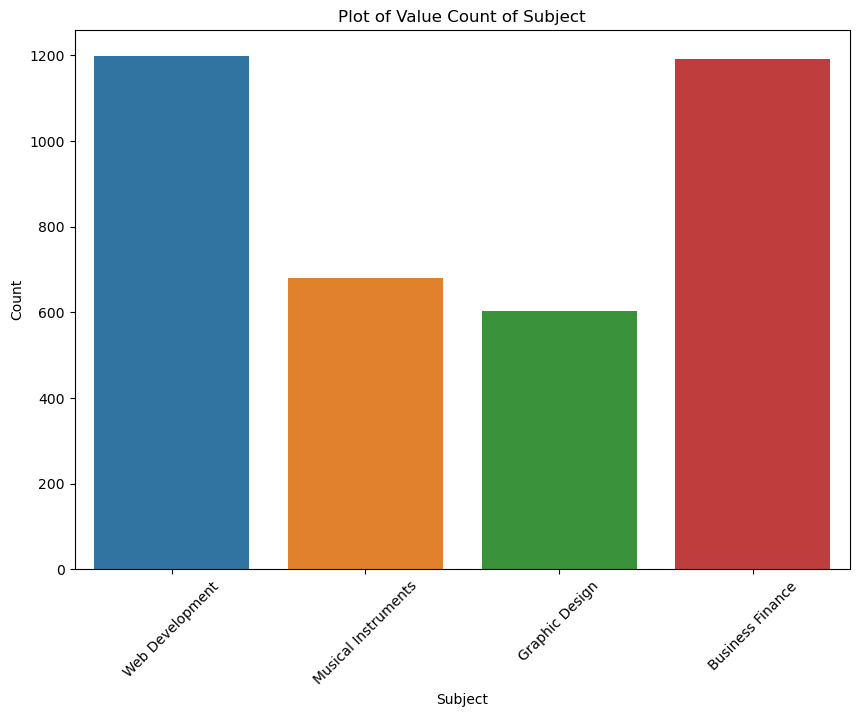

In [14]:
# Plot Distribution of Subject/Value Counts with Pie Chart
plt.figure(figsize=(10, 7))
sns.countplot(x='subject', data=courses_df)
plt.title("Plot of Value Count of Subject")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.xlabel("Subject")
plt.show()

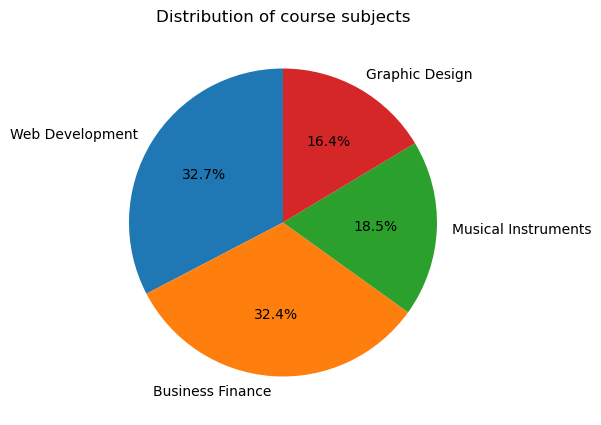

In [29]:
# Plot Distribution of Subject/Value Counts with Pie Chart
plt.figure(figsize=(10, 5))
courses_df['subject'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of course subjects')
plt.ylabel('')
plt.show()

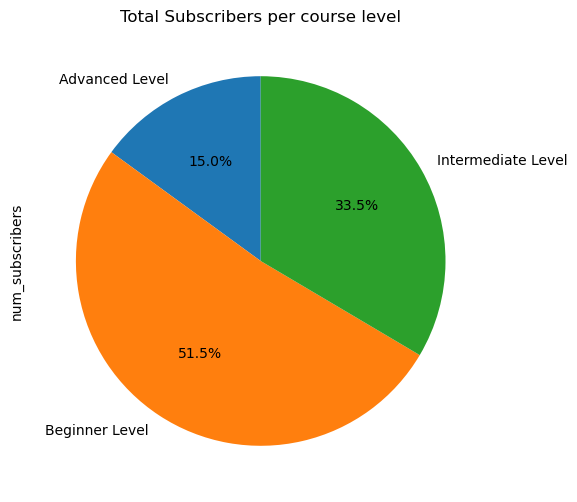

In [16]:
#  How many subscribers per levels
# Grouping by 'level' and summing the 'num_subscribers'
subscriber_counts = courses_df.groupby('level')['num_subscribers'].sum()

# Plotting the pie chart
plt.figure(figsize=(6, 6))  # figure size
subscriber_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)  # Adding percentages
plt.title('Total Subscribers per course level')  # Adding a title

# Displaying the chart
plt.show()

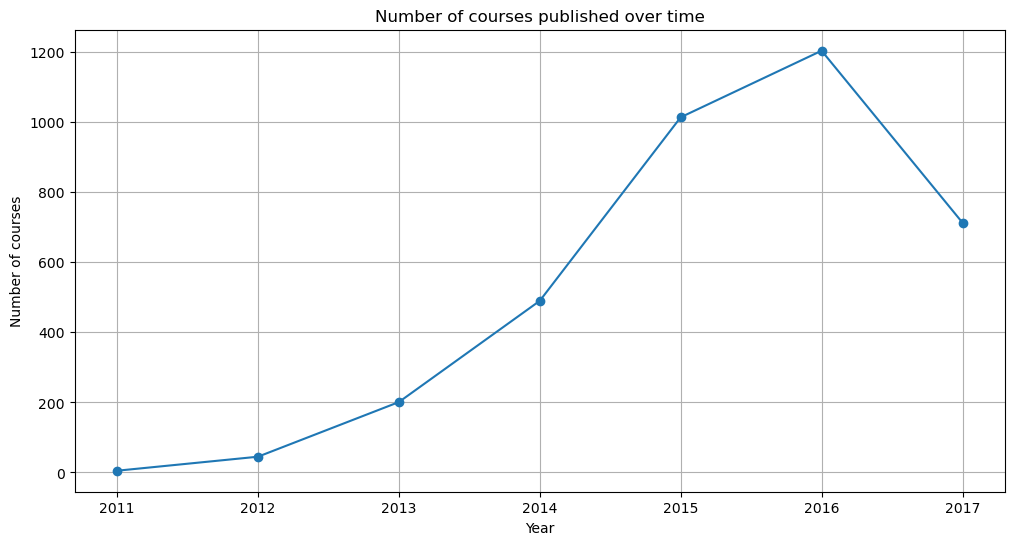

In [17]:
# Graph of the number of courses published over time

# We need to convert the published_time into a datetime format
courses_df['published_time'] = pd.to_datetime(courses_df['published_time'])

# Let's extract the year
courses_df['year'] = courses_df['published_time'].dt.year

# Counting the number of courses published each year
courses_per_year = courses_df['year'].value_counts().sort_index()

# Step 4: Creating the line chart
plt.figure(figsize=(12, 6))
plt.plot(courses_per_year.index, courses_per_year.values, marker='o')
plt.title('Number of courses published over time')
plt.xlabel('Year')
plt.ylabel('Number of courses')
plt.xticks(courses_per_year.index)
plt.grid()
plt.show()

In [18]:
# How many levels per subject
courses_df.groupby('subject')['level'].value_counts()

subject              level             
Business Finance     Beginner Level        472
                     Intermediate Level    434
                     Advanced Level        285
Graphic Design       Beginner Level        285
                     Intermediate Level    184
                     Advanced Level        133
Musical Instruments  Beginner Level        366
                     Intermediate Level    181
                     Advanced Level        133
Web Development      Beginner Level        478
                     Intermediate Level    408
                     Advanced Level        313
Name: count, dtype: int64

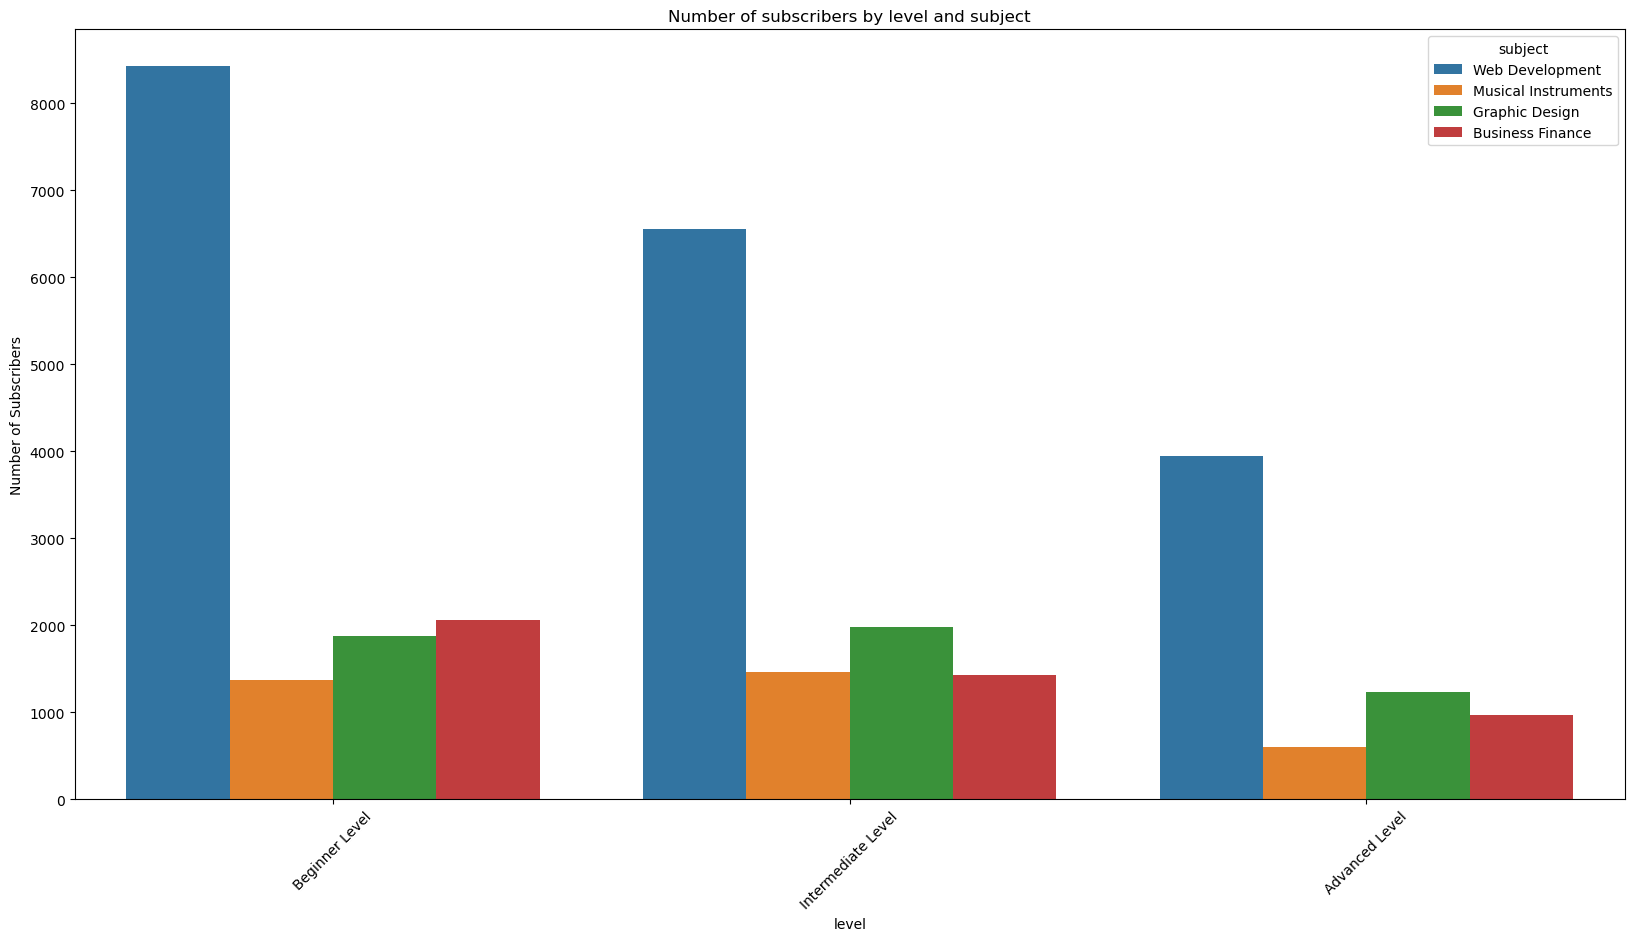

In [19]:
# Let's use seaborn to create the chart
plt.figure(figsize=(20, 10))
sns.barplot(x='level', y='num_subscribers', hue='subject', data=courses_df, ci=None)
plt.title('Number of subscribers by level and subject')
plt.xlabel('level')
plt.ylabel('Number of Subscribers')
plt.xticks(rotation=45)
plt.show()

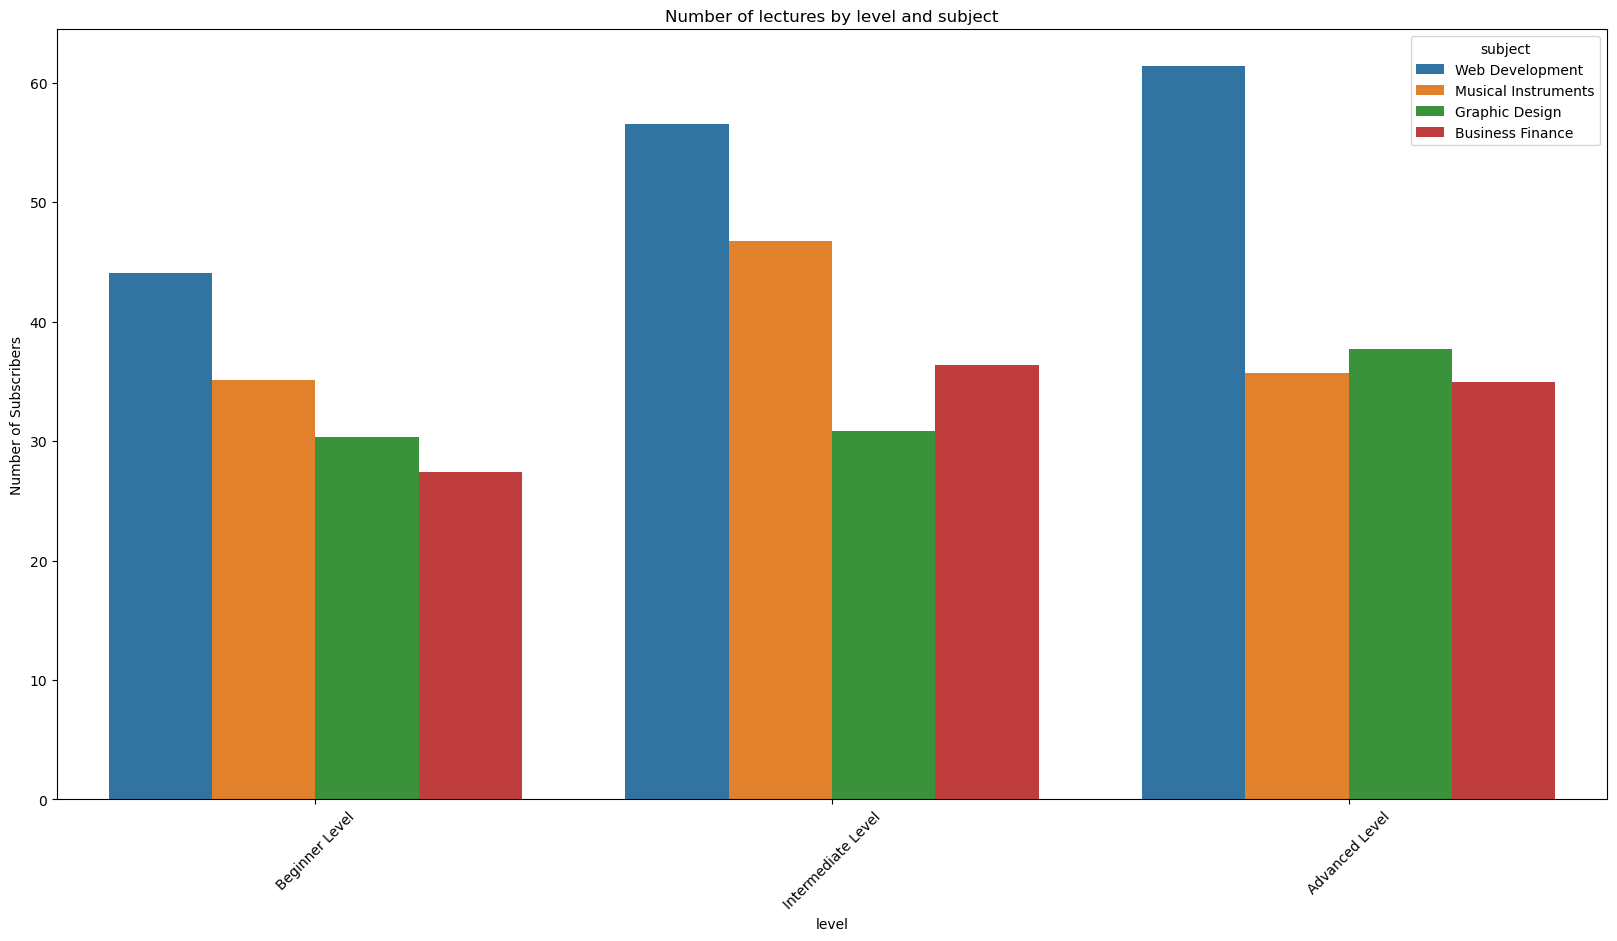

In [20]:
# Chart of the number of lecturers
plt.figure(figsize=(20, 10))
sns.barplot(x='level', y='num_lectures', hue='subject', data=courses_df, ci=None)
plt.title('Number of lectures by level and subject')
plt.xlabel('level')
plt.ylabel('Number of Subscribers')
plt.xticks(rotation=45)
plt.show()

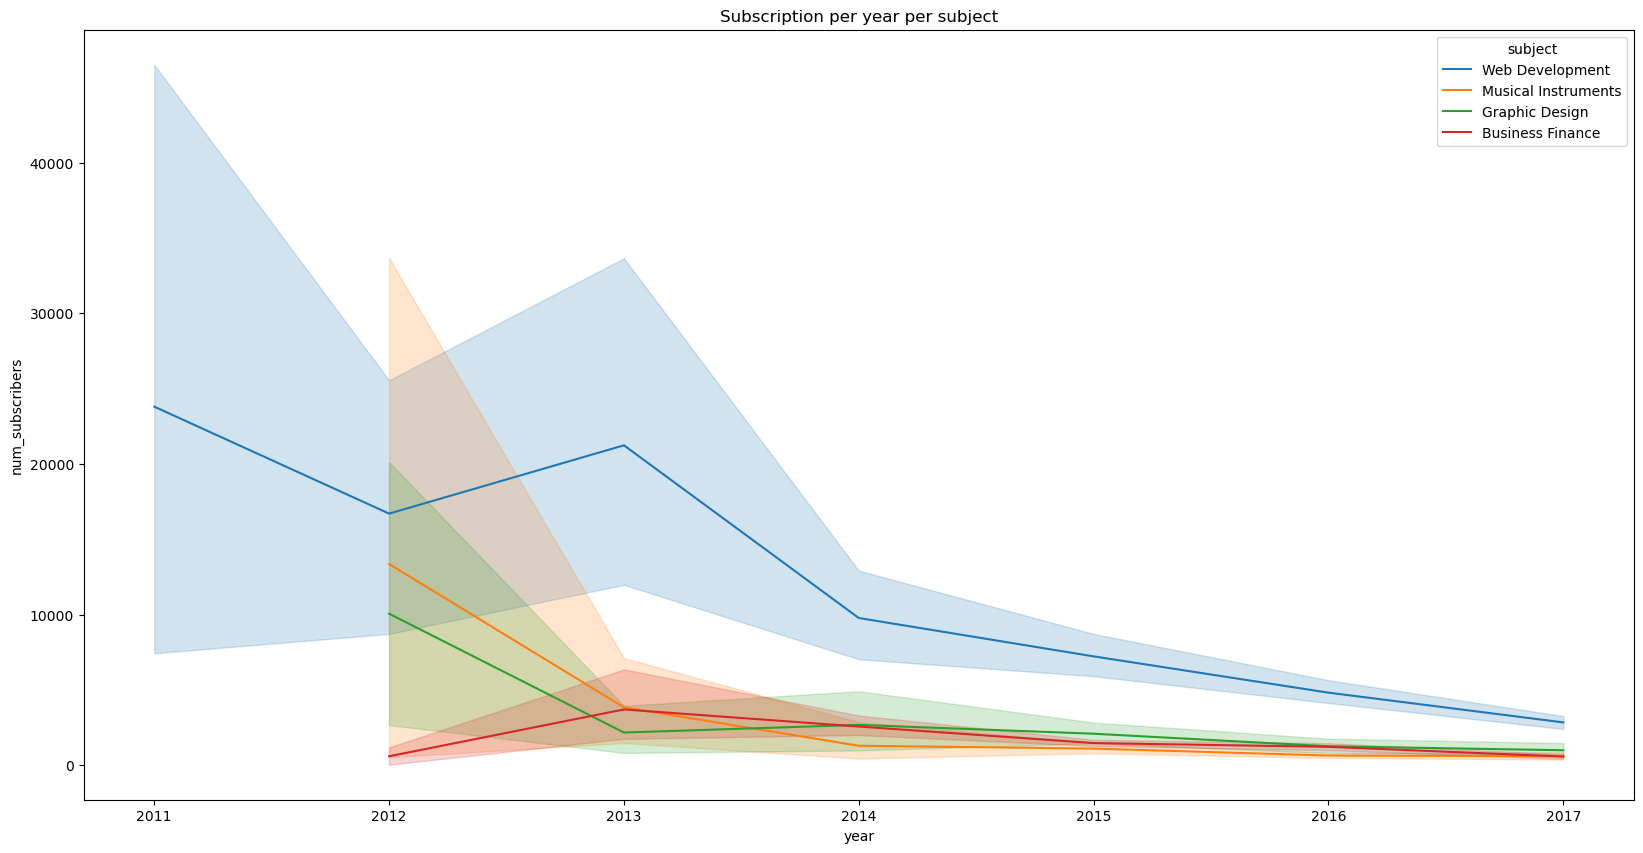

In [21]:
# Chart of the number of subscription per year per subject

plt.figure(figsize=(20, 10))
plt.title("Subscription per year per subject")

# Number of subscribers per year, separated by subject
sns.lineplot(data=courses_df, x='year', y='num_subscribers', hue='subject')

# Showing the plot
plt.show()


#### Vectorizing the title using TF-IDF
We will use the TF-IDF vectorization to convert the titles into numerical vectors

In [22]:
# Initializing the vectorizer
tfidf = TfidfVectorizer()

# Fitting and transforming the course titles
tfidf_matrix = tfidf.fit_transform(courses_df['title'])

# Checkinge shape of the TF-IDF matrix (courses, words)
print(tfidf_matrix.shape)

(3672, 3312)


#### Calculating the cosine similarity

In [23]:
# Cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Let's view the similarity matrix for the first 5 courses
print(cosine_sim[:5, :5])

[[1.         0.16795935 0.16927431 0.         0.        ]
 [0.16795935 1.         0.08124884 0.         0.        ]
 [0.16927431 0.08124884 1.         0.         0.        ]
 [0.         0.         0.         1.         0.63595357]
 [0.         0.         0.         0.63595357 1.        ]]


#### Recommending similar courses

In [24]:
# Function to recommend courses
def recommend_courses(title, courses_df, cosine_sim, num_recommendations = 10):
    
    # Finding close matches to the title
    best_match = process.extractOne(title, courses_df['title'].values)

    if best_match[1] < 80:  # If match score is less than 80%, it's not a good match
         return f"No good match found for the title '{title}'. Did you mean '{best_match[0]}'?"
        
    # The best match will be considered the title the user is searching for
    title = best_match[0]
    
    # Check if the course title exists in the our dataset
    # if title not in courses_df['title'].values:
        # return f"Course '{title}' not found in the dataset."

    # Finding the index of the course that matches the title
    idx = courses_df[courses_df['title'] == title].index[0]
    
    # Getting the similarity scores for this course with all the other courses
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sorting the courses by similarity scores in descending order
    scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Getting the scores of the top N most similar courses. We will exclude the first one, which is the same course
    selected_course_scores = scores[1:num_recommendations+1]
    
    # Courses indices
    selected_course_indices = [i[0] for i in selected_course_scores]
    
    # Returning the top n most similar courses
    return courses_df.iloc[selected_course_indices][['title', 'num_subscribers', 'subject']]

In [28]:
# Testing the function
# Example: Recommend 5 courses similar to "web site programming"
recommended_courses = recommend_courses("web developer", courses_df, cosine_sim, num_recommendations=5)
recommended_courses

,title,num_subscribers,subject
3532,learn become web developer scratch,7062,Web Development
4,become certified web developer,26673,Web Development
3487,become app developer,1935,Web Development
289,become professional web developer version,6851,Web Development
891,learn code become web developer master javascript,2353,Web Development


#### Creating an interface using streamlit

In [26]:
st.title("Course Recommendation System")
st.write("Enter a course title to get recommendations:")

course_title = st.text_input("Course Title", "")

if st.button("Recommend"):
    if course_title:
        recommended_courses = recommend_courses(course_title, courses_df, cosine_sim, num_recommendations=10)
        st.write("10 Recommended Courses:")
        st.write(recommended_courses)
    else:
        st.write("Please enter a course title.")

2024-10-13 13:03:28.558 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.062 
  command:

    streamlit run C:\Users\Eyram\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-10-13 13:03:29.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-13 13:03:29.078 Thread 'MainThread': mi